In [1]:
import pyvisa
import matplotlib.pyplot as plt

In [2]:
rm = pyvisa.ResourceManager()
rm.list_resources()

('USB0::0x0957::0x0407::MY44042361::INSTR',
 'USB0::0x1AB1::0x0610::HDO4A243800216::INSTR',
 'ASRL1::INSTR',
 'USB::0x1AB1::0x0610::HDO4A243800216::INSTR',
 'USB::0x0957::0x0407::MY44042361::INSTR')

In [3]:
scope = rm.open_resource('USB::0x1AB1::0x0610::HDO4A243800216::INSTR')



In [4]:
scope.write(f"CHAN{1}:DISP ON")
# scope.write(f"CHAN{2}:DISP ON")

15

In [4]:
scope.query(":WAVeform:MODE?")



'NORM\n'

In [41]:
scope.write(":RUN")

6

In [42]:

scope.write(":WAVeform:MODE RAW;:ACQuire:TYPE AVERages;:ACQ:AVER 64;")
scope.write(":WAVeform:FORMat ASC")
scope.write(":ACQuire:MDEPth 10k")
scope.write(":STOP")
scope.write(":WAVeform:POINts 10000")
# scope.write(":WAV:DATA?")

# data_default= scope.read_raw()
# x = data_default[11:]

data_default = scope.query(":WAV:DATA?")
data_default_float =  [float(x) for x in data_default.split(',')]
scope.write(":RUN")

6

In [35]:
# convert spectra to floats: 
# "(0x8E - YORigin - YREFerence) × YINCrement"

yOrigin = float(scope.query("WAV:YOR?"))
yref = float(scope.query("WAV:YREF?"))
yinc = float(scope.query("WAV:YINC?"))
data_default_float = [(i - yOrigin - yref) * yinc for i in x]

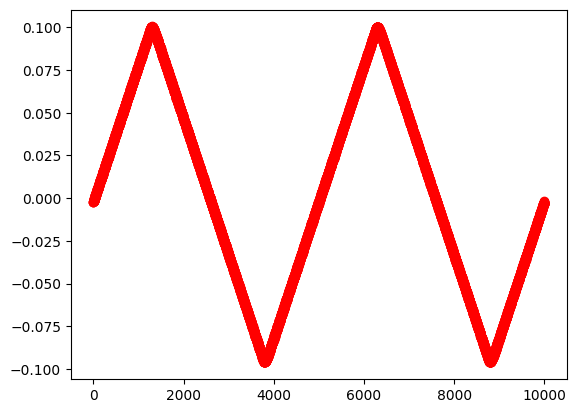

In [43]:
fig, ax = plt.subplots()
ax.plot([x for x, _ in enumerate(data_default_float)],data_default_float, 'ro')

In [8]:
scope.write(":WAV:SOUR CHAN1")
scope.write(":WAVeform:MODE MAX;:ACQuire:TYPE AVERages;:ACQ:AVER 64;")
scope.write(":WAVeform:FORMat ASC")
scope.write(":ACQ:MDEP AUTO")

scope.write(":WAV:SOUR CHAN2")
scope.write(":WAVeform:MODE MAX;:ACQuire:TYPE AVERages;:ACQ:AVER 64;")
scope.write(":WAVeform:FORMat ASC")
scope.write(":ACQ:MDEP AUTO")


16

In [17]:
scope.write(f"CHAN{1}:SCAL {0.1}")
scope.write(f"CHAN{2}:SCAL {0.1}")

16

In [10]:
def get_channel_trace(scope, channel=1, depth="10k"):
    # self.scope.write(":STOP")
    # if channel display is 'off', then don't do anything and just return.
    # if int(scope.query(":CHAN{channel}:DISP?").strip()) == 0:
    #     return

    scope.write(f":WAV:SOUR CHAN{channel}")
    scope.write(f":ACQuire:TYPE AVERages;:ACQ:AVER {64};")
    scope.write(":WAV:FORM ASC;:WAV:MODE MAX")
    scope.write(f":ACQ:MDEP {depth}")
    x_increment = float(scope.query("WAV:XINC?"))
    y_increment = float(scope.query("WAV:YINC?"))
    y_reference = float(scope.query("WAV:YREF?"))
    start_time = float(scope.query("WAV:XOR?"))

    data = scope.query(":WAV:DATA?")
    # data = scope.read()
    if scope.query("WAV:MODE?").strip() == "NORM":
        y_reference = y_reference * y_increment
    # data = [(float(x) - y_reference) *
    #         y_increment for x in data.strip().split(',')]
    data = [float(x) for x in data.split(',')]
    times = [start_time+(x_increment * x) for x in range(len(data))]

    return times, data

times, data = get_channel_trace(scope, 1)
times2, data2 = get_channel_trace(scope, 2)

In [153]:
# data = scope.query(":WAV:DATA?")

# data = data.split(',')
# data = [float(x) for x in data]



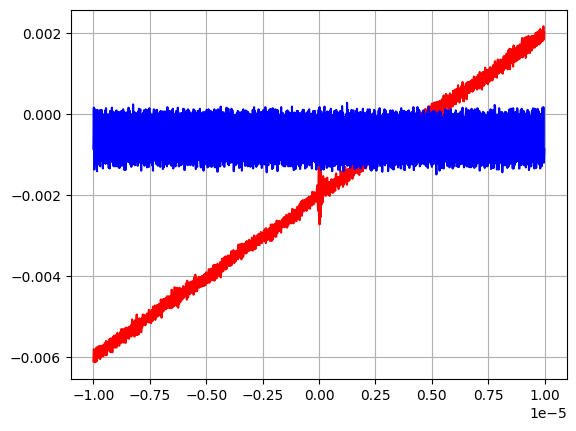

In [11]:
fig, ax = plt.subplots()
# ax.plot([i for i,x in enumerate(data)], data,'r-')
ax.plot(times,data,'r-')
ax.plot(times2,data2,'b-')
plt.grid()

In [89]:
scope.close()